# Northwind Data Analysis

## The assignment

Conduct 4 hypothesis tests on data extracted from the Northwind database. 

<a id="top"></a>

# Contents
### - [Import libraries](#importlibraries)
### - [Helper functions](#functions)
### - [Exploratory data analysis](#eda)
### - [Hypothesis test 1](#hypo1): Discounts and orders
### - [Hypothesis test 2](#hypo2): Sales by London office versus PNW offices
### - [Hypothesis test 3](#hypo3): Sales in 2013 v. 2014
### - [Hypothesis test 4](#hypo4): Orders and beverages
### - [Conclusions](#conclusions)
### - [Future work](#futurework)

<a id="importlibraries"></a>

# Import libraries

In [2]:
#For the ORM:
import sqlalchemy 
from sqlalchemy import create_engine #To connect to the database
from sqlalchemy.orm import Session, sessionmaker #To interact with the database as object
from sqlalchemy import inspect #To look at tables and column names

#For building DataFrames from SQL queries:
import pandas as pd #To read in parts of the database as DataFrames

#For calculations:
import numpy as np #To perform mathematical operations and manipulate arrays

#For hypothesis testing:
from scipy import stats #To find t and p values with ttest_ind
from sklearn.utils import resample #To pull samples from a small distribution (bootstrapping)

#For visualizations:
import matplotlib.pyplot as plt #For creating visualizations
%matplotlib inline
import seaborn as sns #For plotting histograms with kdes

<a id="functions"></a>

[(Back to top)](#top)
# Helper functions

In [3]:
#Instantiate a session of the ORM
#Connect to the sqlite database file
engine = create_engine('sqlite:///Northwind_small.sqlite', echo = True)
#Bind a session factory to the engine
Session = sessionmaker(bind=engine)
#Instantiate a session
session = Session()

In [3]:
#An object to get a first look at the database
inspector = inspect(engine)

2019-02-04 13:48:18,752 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-02-04 13:48:18,756 INFO sqlalchemy.engine.base.Engine ()
2019-02-04 13:48:18,757 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-02-04 13:48:18,758 INFO sqlalchemy.engine.base.Engine ()


In [4]:
#Make a dict of list of names of all the columns in all the tables
#for easy reference

#Get list of all table names
table_names = inspector.get_table_names()

tables_columns = dict()
#For each table name
for table in table_names:
    column_names = []
    #for each column in the table, get just the name
    for column in inspector.get_columns(table):
        column_names.append(column['name'])
    tables_columns[table] = column_names

2019-02-04 13:48:20,121 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-02-04 13:48:20,122 INFO sqlalchemy.engine.base.Engine ()
2019-02-04 13:48:20,124 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Category")
2019-02-04 13:48:20,125 INFO sqlalchemy.engine.base.Engine ()
2019-02-04 13:48:20,128 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Customer")
2019-02-04 13:48:20,128 INFO sqlalchemy.engine.base.Engine ()
2019-02-04 13:48:20,131 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("CustomerCustomerDemo")
2019-02-04 13:48:20,131 INFO sqlalchemy.engine.base.Engine ()
2019-02-04 13:48:20,133 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("CustomerDemographic")
2019-02-04 13:48:20,134 INFO sqlalchemy.engine.base.Engine ()
2019-02-04 13:48:20,136 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Employee")
2019-02-04 13:48:20,137 INFO sqlalchemy.engine.base.Engine ()
2019-02-04 13:48:20,140 INFO sqlalche

In [5]:
#Generic Query to show totals from invoices.
#Listed by the last name of the sales rep who fulfilled the order.
#Use to build specific queries about sales and revenue.
invoices = pd.read_sql_query('''SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            GROUP BY od.OrderId
                            ORDER BY e.LastName
                    ''', engine)

2019-02-04 13:48:23,976 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            GROUP BY od.OrderId
                            ORDER BY e.LastName
                    
2019-02-04 13:48:23,977 INFO sqlalchemy.engine.base.Engine ()


In [6]:
#Run a hypothesis using "bootstrapping" to resample data
#of a small sample size and irregular distribution
#via https://codingdisciple.com/bootstrap-hypothesis-testing.html
def bootstrap(alpha, control, treatment, title, permus = 10000):

    #Step 1: combine the control and treatment groups
    combo = np.concatenate((control, treatment), axis = 0) #both dists combined for taking samples

    permus_control = []
    permus_treatment = []

    #Step 2: generate many new control and treatment groups by
    #resampling with replacement from the combo group
    for i in range(permus): #Generate this many permutations
        np.random.seed(i) #seed for consistency
        permus_control.append(resample(combo, n_samples = len(control)))
        permus_treatment.append(resample(combo, n_samples = len(treatment)))
    
    #Step 3: Take the difference in means between the two sets of permutations
    diff_boot_means = (np.mean(permus_control, axis = 1) - np.mean(permus_treatment, axis = 1))

    #Step 4: Calculate the observed difference in mean, meaning the difference
    #between the two actual means of the distributions
    observed_diff = (np.mean(control) - np.mean(treatment))

    #Step 5: Find the p value by counting how many differences in mean were  
    #greater than or equal to the observed difference in means.
    means_below_observed = diff_boot_means[diff_boot_means >= observed_diff].shape[0]
    p = means_below_observed / permus
    
    #Step 6: Visualize the distribution

    #Get the difference between control and treatment to 
    #find the confidence interval
    lower_bound = np.percentile(diff_boot_means, 2.5)
    upper_bound = np.percentile(diff_boot_means, 97.5)

    #Plot the differences in means between the 2 bootstrapped groups with the p value
    fig = plt.figure(figsize = (10,5))
    ax = plt.hist(diff_boot_means, bins = 30)
    plt.axvline(observed_diff, color = 'red', label = 'p')
    plt.axvline(lower_bound, color = 'lightgreen', label = 'lower bound')
    plt.axvline(upper_bound, color = 'darkgreen', label = 'upper bound')
    plt.xlabel('Difference in means')
    plt.ylabel('Frequency')
    plt.legend()
    plot_title = 'Bootstrapped population: ' + title
    plt.title(plot_title)
    plt.show()
    
    #Step 7: Print a summary
    print('Observed difference between the means:', observed_diff)
    print('The p value is', p, '.')
    print('Alpha was', alpha, '.')
    print('Cohen\'s D is', round(cohend(control, treatment), 2))

In [7]:
#A way of measuring "effect" relative to the parameters of the
#control and treatment groups.
# 0.2 may be considered a "small" effect; 0.5 "medium"; 0.8 "large"
def cohend(control, treatment):
    numer = control.mean() - treatment.mean()
    var = ((len(control) * control.var()) + (len(treatment) * treatment.var())) / len(control) + len(treatment)
    denom = np.sqrt(var)
    return numer / denom

<a id="eda"></a>

[(Back to top)](#top)

# Exploratory data analysis: What is Northwind?

## Products 

### What does the company sell?

In [8]:
#What does the company sell?
#Look at descriptions of categories for items sold

product_categories = pd.read_sql_query('''SELECT c.CategoryName, c.Description
                                    FROM Category c
                                ''', engine)
product_categories

2019-02-04 13:48:33,282 INFO sqlalchemy.engine.base.Engine SELECT c.CategoryName, c.Description
                                    FROM Category c
                                
2019-02-04 13:48:33,282 INFO sqlalchemy.engine.base.Engine ()


,CategoryName,Description
0,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,Confections,"Desserts, candies, and sweet breads"
3,Dairy Products,Cheeses
4,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,Meat/Poultry,Prepared meats
6,Produce,Dried fruit and bean curd
7,Seafood,Seaweed and fish


It's a food distributor.

### How are products and revenue distributed by category?

In [9]:
#How are products and revenue distributed by category?
#This includes discontinued products
#To  view without, add in   WHERE p.Discontinued == 0
cat_rev = pd.read_sql_query('''SELECT ca.CategoryName,
                                COUNT(DISTINCT p.ProductName) Products,
                                SUM((od.UnitPrice * (1 - od.Discount) * od.Quantity)) Revenue
                                FROM OrderDetail od
                                JOIN Product p ON od.ProductId = p.Id
                                JOIN Category ca ON p.CategoryId = ca.Id
                                GROUP BY ca.CategoryName
                                ORDER BY Revenue DESC
                            ''', engine)
cat_rev

2019-02-04 13:48:35,583 INFO sqlalchemy.engine.base.Engine SELECT ca.CategoryName,
                                COUNT(DISTINCT p.ProductName) Products,
                                SUM((od.UnitPrice * (1 - od.Discount) * od.Quantity)) Revenue
                                FROM OrderDetail od
                                JOIN Product p ON od.ProductId = p.Id
                                JOIN Category ca ON p.CategoryId = ca.Id
                                GROUP BY ca.CategoryName
                                ORDER BY Revenue DESC
                            
2019-02-04 13:48:35,584 INFO sqlalchemy.engine.base.Engine ()


,CategoryName,Products,Revenue
0,Beverages,12,267868.1800
1,Dairy Products,10,234507.2850
2,Confections,13,167357.2250
3,Meat/Poultry,6,163022.3595
4,Seafood,12,131261.7375
5,Condiments,12,106047.0850
6,Produce,5,99984.5800
7,Grains/Cereals,7,95744.5875


It looks like the money's in the booze!

### How many different products are sold?

In [10]:
print(cat_rev['Products'].sum(), 'different products sold.')

77 different products sold.


## Customers

### How many does Northwind serve?

In [11]:
customers = pd.read_sql_query('''SELECT c.*
                                FROM Customer c
                                ''', engine)
print(customers.shape[0], 'customers served.')

2019-02-04 13:48:39,191 INFO sqlalchemy.engine.base.Engine SELECT c.*
                                FROM Customer c
                                
2019-02-04 13:48:39,192 INFO sqlalchemy.engine.base.Engine ()
91 customers served.


If we run experiments related to customers, we may need to use resampling since this population is small.

### How are customers distributed by region?

In [12]:
#How are customers distributed by region?
customer_by_region = pd.read_sql_query('''SELECT c.Region
                                            FROM Customer c
                                        ''', engine)

customer_by_region['Region'].value_counts()

2019-02-04 13:48:42,863 INFO sqlalchemy.engine.base.Engine SELECT c.Region
                                            FROM Customer c
                                        
2019-02-04 13:48:42,863 INFO sqlalchemy.engine.base.Engine ()


Western Europe     28
South America      16
North America      16
Southern Europe    10
British Isles       8
Central America     5
Northern Europe     4
Scandinavia         3
Eastern Europe      1
Name: Region, dtype: int64

For future work, we could look at expanding the customer base into Eastern Europe.

### How many customers does each company have?

In [13]:
#Look at how many customers each company has
df = pd.read_sql_query("""SELECT Customer.Id, Customer.CompanyName
                            FROM Customer
                            ORDER BY Customer.CompanyName
                        """, engine)

sum(df['CompanyName'].value_counts() > 1) #How many companies have more than one customer?

2019-02-04 13:48:45,783 INFO sqlalchemy.engine.base.Engine SELECT Customer.Id, Customer.CompanyName
                            FROM Customer
                            ORDER BY Customer.CompanyName
                        
2019-02-04 13:48:45,784 INFO sqlalchemy.engine.base.Engine ()


0

Each company has only one customer in the database. Orders can therefore be counted by customer or by company.

## Employees

### Who works at Northwind?

In [14]:
#List each employee with name, title, office location, and sales summaries
df = pd.read_sql_query('''SELECT e.Id, e.LastName, e.FirstName, e.Title, e.City Office, 
                            COUNT(DISTINCT od.OrderId) Orders_fulfilled,
                            SUM(od.Quantity) Unit_quantities_sold
                            FROM Employee e
                            JOIN [Order] o ON e.Id = o.EmployeeId
                            JOIN OrderDetail od ON o.Id = od.OrderId
                            JOIN EmployeeTerritory et ON et.EmployeeId = e.Id
                            JOIN Territory t on et.Territoryid = t.Id
                            JOIN Region r on t.RegionId = r.Id
                            GROUP BY e.Id
                            ORDER BY e.LastName
                        ''', engine)
df

2019-02-04 13:48:49,136 INFO sqlalchemy.engine.base.Engine SELECT e.Id, e.LastName, e.FirstName, e.Title, e.City Office, 
                            COUNT(DISTINCT od.OrderId) Orders_fulfilled,
                            SUM(od.Quantity) Unit_quantities_sold
                            FROM Employee e
                            JOIN [Order] o ON e.Id = o.EmployeeId
                            JOIN OrderDetail od ON o.Id = od.OrderId
                            JOIN EmployeeTerritory et ON et.EmployeeId = e.Id
                            JOIN Territory t on et.Territoryid = t.Id
                            JOIN Region r on t.RegionId = r.Id
                            GROUP BY e.Id
                            ORDER BY e.LastName
                        
2019-02-04 13:48:49,137 INFO sqlalchemy.engine.base.Engine ()


,Id,LastName,FirstName,Title,Office,Orders_fulfilled,Unit_quantities_sold
0,5,Buchanan,Steven,Sales Manager,London,42,21252
1,8,Callahan,Laura,Inside Sales Coordinator,Seattle,104,23652
2,1,Davolio,Nancy,Sales Representative,Seattle,123,15624
3,9,Dodsworth,Anne,Sales Representative,London,43,18690
4,2,Fuller,Andrew,"Vice President, Sales",Tacoma,96,42385
5,7,King,Robert,Sales Representative,London,72,46540
6,3,Leverling,Janet,Sales Representative,Kirkland,127,31408
7,4,Peacock,Margaret,Sales Representative,Redmond,156,29394
8,6,Suyama,Michael,Sales Representative,London,67,17635


9 employees: 4 in London, 5 in the PNW, all working in sales.

## Summary of EDA

We're looking at a food distributor which sells 77 products in 8 different categories. 9 employees in 2 locations make sales to 91 customers. We can use order details to run experiments on customer preferences. By combining order details into invoices, we'll be able to examine sales by employees and calculate revenue.

# Hypothesis Tests

Each experiment will be presented with the following headings:

- **Question**: Asked by our non-technical stakeholders, based on anecdotal evidence, hunches, &c. Not data-driven.
- **Measurement**: How to make the initial question into quantifiable, testable hypotheses.
- **Hypotheses**: Null and alternative; to be tested under the scientific method.
- **Data**: How the control and treatment groups will be formed.
- **Experiment**: Test the null hypothesis by comparing the treatment group to the control group.
- **Result**: Rejection or failure to reject the null hypothesis.
- **Insights**: Conclusions to be drawn from the experiment; next steps.

<a id="hypo1"></a>

[(Back to top)](#top)

# Hypothesis test 1: Discounts and orders

## Part 1

>**Do discounts have a statistically significant effect on the number of products customers order?** If so, at what level(s) of discount?

### What are we measuring?

This is a question about customer choice. In order to determine whether discounts affect how many products a customer buys, we must compare the quantities of products bought by the customer, with and without discounts.

### The hypotheses

>**Null hypothesis**: Discount does not have an effect on the number of products ordered by a customer. 

>>Control (orders without discount) = Treatment (orders with discount)

>**Alternative hypothesis**: Discount has an effect on the number of products ordered by a customer.

>>Control (orders without discount) != Treatment (orders with discount)

### The data

We'll write a query to pull from the database to compare the quantities of products ordered by each customer at each of the various discount levels. (The query will work for Part 1 and Part 2 of the question.)

![orderdiscounts.png](https://raw.githubusercontent.com/ssrosa/northwind_hypothesis_tests/master/images/orderdiscounts.png)

In [15]:
#Compare quantities ordered with and without discounts.
#Note that discounts of 06 and under are grouped together.
orders_discounts = pd.read_sql_query('''SELECT [Order].CustomerId,
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.0 
                                THEN 1 ELSE 0 END
                                ) no_disc,
                            SUM(
                                CASE WHEN OrderDetail.Discount != 0.0 
                                THEN 1 ELSE 0 END
                                ) all_discs,                                
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.0
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_no_disc,

                            SUM(
                                CASE WHEN OrderDetail.Discount != 0.0
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_all_discs,
                            SUM(
                                CASE WHEN OrderDetail.Discount < 0.06 
                                AND OrderDetail.Discount > 0.0
                                THEN 1 ELSE 0 END
                                ) disc06,                            
                            SUM(
                                CASE WHEN OrderDetail.Discount < 0.06
                                AND OrderDetail.Discount > 0.0
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_disc06,
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.1 
                                THEN 1 ELSE 0 END
                                ) disc10,
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.1
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_disc10,                            
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.15 
                                THEN 1 ELSE 0 END
                                ) disc15,
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.15
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_disc15,                            
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.2 
                                THEN 1 ELSE 0 END
                                ) disc20,
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.2
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_disc20,                                
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.25 
                                THEN 1 ELSE 0 END
                                ) disc25,
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.25
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_disc25,
                            Count(*) total_orders,
                            SUM(OrderDetail.Quantity) total_quantities
                            FROM OrderDetail 
                            INNER JOIN [Order] on OrderDetail.OrderId = [Order].Id
                            GROUP BY [Order].CustomerId
                            ORDER BY [Order].CustomerId ASC
                        ''', engine)


2019-02-04 13:48:55,616 INFO sqlalchemy.engine.base.Engine SELECT [Order].CustomerId,
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.0 
                                THEN 1 ELSE 0 END
                                ) no_disc,
                            SUM(
                                CASE WHEN OrderDetail.Discount != 0.0 
                                THEN 1 ELSE 0 END
                                ) all_discs,                                
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.0
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_no_disc,

                            SUM(
                                CASE WHEN OrderDetail.Discount != 0.0
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_all_discs,
                            SUM(
        

In [16]:
#Take a look at the table resulting from above query
#It includes data for Hypothesis Test Part 1 and Part 2
orders_discounts.head()

,CustomerId,no_disc,all_discs,quant_no_disc,quant_all_discs,disc06,quant_disc06,disc10,quant_disc10,disc15,quant_disc15,disc20,quant_disc20,disc25,quant_disc25,total_orders,total_quantities
0,ALFKI,6,6,78,96,2,56,0,0,0,0,1,2,3,38,12,174
1,ANATR,10,0,63,0,0,0,0,0,0,0,0,0,0,0,10,63
2,ANTO,9,8,211,148,0,0,4,80,4,68,0,0,0,0,17,359
3,AROUT,23,7,439,211,3,128,2,40,1,28,1,15,0,0,30,650
4,BERGS,34,18,632,369,0,0,10,161,0,0,0,0,8,208,52,1001


Let's take a look at how our data is distributed.

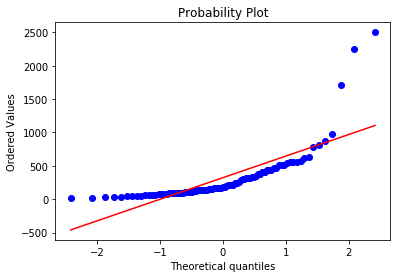

In [17]:
#QQ plot with stats.probplot to check for normality
normality_check = stats.probplot(orders_discounts['quant_no_disc'], plot = plt)

The control group doesn't look normally distributed, so we may want to resample it somehow to create a normal distribution that we can work with.

How big is the sample here?

In [19]:
print('Control group mean:', orders_discounts['quant_no_disc'].mean())
print('Treatment group mean:', orders_discounts['quant_all_discs'].mean())
print("The population distribution has only", orders_discounts.shape[0], "values.")

Control group mean: 321.3370786516854
Treatment group mean: 255.25842696629215
The population distribution has only 89 values.


The means are different, but we don't know if they are different *enough* to be statistically significant. Both groups have a small sample size (89), so we can simulate larger sizes for both by resampling. Then we can plot the resampled distributions and find the p value.

### The experiment: resampling by bootstrapping

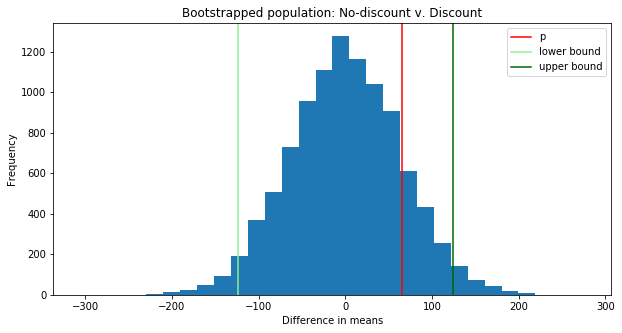

Observed difference between the means: 66.07865168539323
The p value is 0.1467 .
Alpha was 0.05 .
Cohen's D is 0.11


In [18]:
alpha = 0.05 # The value chosen for comparison with the test statistic.
#Test statistic will need to be lower than this in order to reject the null hypothesis.

control1 = orders_discounts['quant_no_disc'] #The quantities of items ordered without discount
treatment1 = orders_discounts['quant_all_discs'] #The quantitites of items ordered with a discount

#Put the two groups of data into arrays to be resampled &c
bootstrap(alpha, control1, treatment1, 'No-discount v. Discount')

#Results for no-discount v. discount

### Part 1 Result:

Failure to reject null hypothesis. Discount does not have an effect on the number of products ordered by a customer.

*However . . .*

This experiment only tested for the presence or absence of a discount. 

## Part 2: 

>Do discounts have a statistically significant effect on the number of products customers order? **If so, at what level(s) of discount?**

We can run the same experiment again to compare no-discount order quantites to order quantities at each level of discount.

### What are we measuring?

This time we measure quantities at each level of discount one at a time against quantities ordered without discount. They're still grouped by customer. We'll run the experiment five times, once per discount level.

### The hypotheses

>**Null hypothesis**: Discount at 06%/10%/15%/20%/25% does not have an effect on the number of products ordered by a customer. 

>>Control (orders without discount) = Treatment (orders with discount)

>**Alternative hypothesis**: Discount at 06%/10%/15%/20%/25% has an effect on the number of products ordered by a customer.

>>Control (orders without discount) != Treatment (orders with discount)

### The data

We can use the data from Part 1 because it includes columns for quantities ordered at each discount level. We'll draw out the relevant columns from the table created above.

In [19]:
#Treatment groups with only the values associated with each level of discount
#Note that .06 discount means all discount levels up to .06
disc06 = orders_discounts['quant_disc06'] #quantities of items ordered with 06% discount
disc10 = orders_discounts['quant_disc10'] #quantities of items ordered with 10% discount
disc15 = orders_discounts['quant_disc15'] #quantities of items ordered with 15% discount
disc20 = orders_discounts['quant_disc20'] #quantities of items ordered with 20% discount
disc25 = orders_discounts['quant_disc25'] #quantities of items ordered with 25% discount

#Drop the zero values from these groups
disc06 = disc06[disc06 != 0]
disc10 = disc10[disc10 != 0]
disc15 = disc15[disc15 != 0]
disc20 = disc20[disc20 != 0]
disc25 = disc25[disc25 != 0]

#list of treatment groups
treatments = [disc06, disc10, disc15, disc20, disc25]

#List of string values of discounts, for labelling
discounts = ['No-discount v. .06 discount', 
             'No-discount v. .10 discount',
             'No-discount v. .15 discount',
             'No-discount v. .20 discount',
             'No-discount v. .25 discount']

#Zip together the above three lists to iterate over them all at once
treatments_discounts = list(zip(treatments, discounts))

We've clustered the data so that we can iterate over it, running the same experiment on the control group with a different treatment group each time.

### The experiment: resampling by bootstrapping (5 iterations)

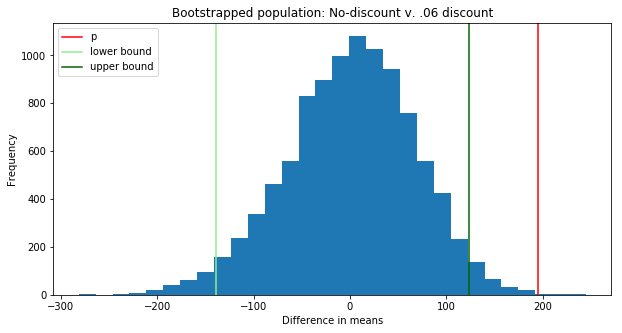

Observed difference between the means: 194.65415182241708
The p value is 0.001 .
Alpha was 0.05 .
Cohen's D is 0.46


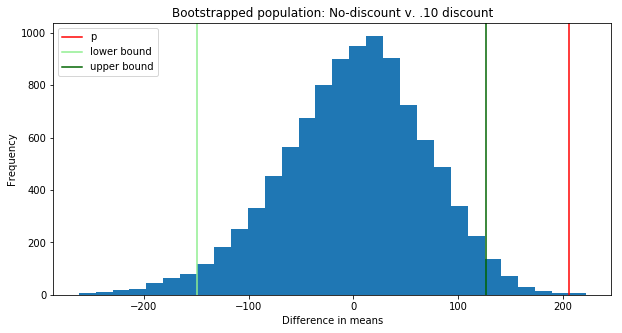

Observed difference between the means: 206.4423418095801
The p value is 0.0005 .
Alpha was 0.05 .
Cohen's D is 0.5


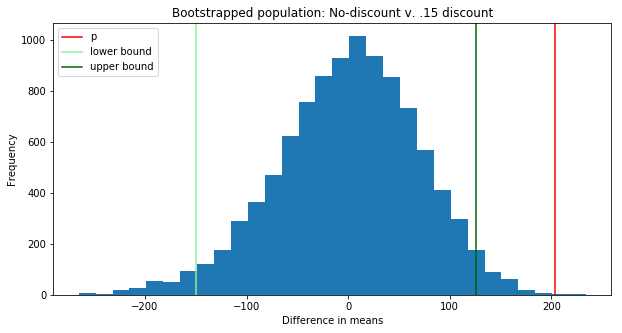

Observed difference between the means: 204.07392075694855
The p value is 0.0008 .
Alpha was 0.05 .
Cohen's D is 0.49


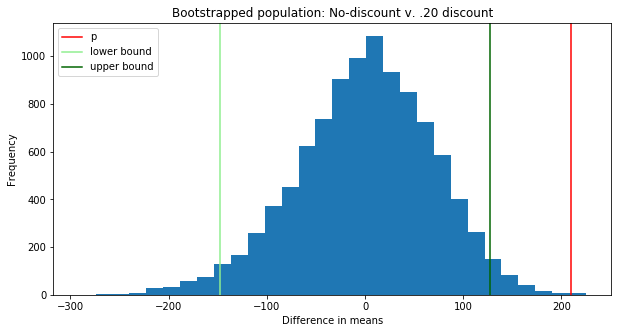

Observed difference between the means: 209.7729760875828
The p value is 0.0006 .
Alpha was 0.05 .
Cohen's D is 0.5


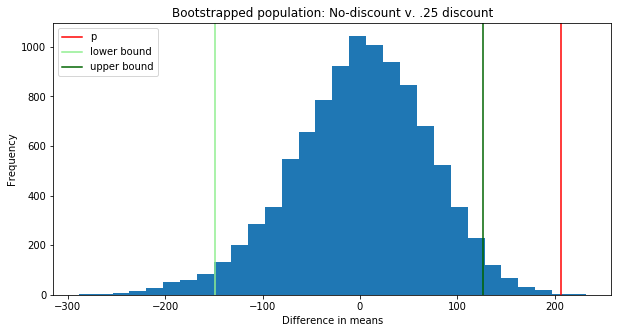

Observed difference between the means: 206.88971023063274
The p value is 0.0004 .
Alpha was 0.05 .
Cohen's D is 0.49


In [20]:
#Resampling by bootstrapping

alpha = 0.05 # The value chosen for comparison with the test statistic.
#Test statistic will need to be lower than this in order to reject the null hypothesis.

permus = 10000 #number of samples to take

#Iterate over the three lists:
#Build permutations of sample distributions,
#Find and print p values,
#Plot each distribution
for treatment, discount in treatments_discounts:
    bootstrap(alpha, control1, treatment, discount)

### Result

Null hypothesis is rejected; alternative hypothesis is accepted.

Discount at 06%/10%/15%/20%/25% has an effect on the number of products ordered by a customer. (At all five levels!)

The effect size in each case gets a Cohen's D of around 0.5, a "medium" effect, and the observed difference in means in each case was enormous.

By comparing the means we can tell that customers seem to order *more* of each product without a discount than with a discount, but strictly speaking, our experiment does not tell us this. We'd have to run another experiment using a one-tailed test in order to reach a greater-than or less-than result.

In [21]:
#Optional discussion: Why did we remove the 0 values?
def optional_discussion_zeros():
    print('Control mean:', control1.mean())
    print('Discount 06 mean without zero values:', disc06.mean())
    print('Discount 06 mean with zero values:', orders_discounts['quant_disc06'].mean())
    print('\n')
    print('Non-zero values in the control group:')
    print(len(orders_discounts[orders_discounts['quant_no_disc'] != 0]), 'out of', len(orders_discounts['quant_no_disc']))
    print('Non-zero values in the treatment groups:')
    print(len(orders_discounts[orders_discounts['quant_disc06'] != 0]), 'out of', len(orders_discounts['quant_disc06']))
    print(len(orders_discounts[orders_discounts['quant_disc10'] != 0]), 'out of', len(orders_discounts['quant_disc10']))
    print(len(orders_discounts[orders_discounts['quant_disc15'] != 0]), 'out of', len(orders_discounts['quant_disc15']))
    print(len(orders_discounts[orders_discounts['quant_disc20'] != 0]), 'out of', len(orders_discounts['quant_disc20']))
    print(len(orders_discounts[orders_discounts['quant_disc25'] != 0]), 'out of', len(orders_discounts['quant_disc25']))
    print('\n')
    print('When left in, the zero values caused the observed difference in means to be even higher than it was in this run of the experiment. The p-value was even more infinitesimally low. The level of significance was similar but the visualizations and statistics were much less readable.')


In [55]:
#Uncomment to view
#optional_discussion_zeros()

## Insights

What accounts for the different result between the two experiments? The first experiment tells us that, **broadly speaking, discounts do not have an effect** on quantities of products that customers choose to buy. This suggests that **marketing efforts** to push discounts or to stop offering them **won't have a meangingful effect** on orders.

The second experiment tells us that customers order **different quantities of items without discount** than at each individual level of discount, and **this makes sense**. Discounts at any given level may only be offered some of the time for some of the products, not all the time for all prodcuts, so it would be odd if customers were ordering the same quantity of products at each discount level and without any discount. In other words, we  can reasonably expect to reject that null hypothesis in a real-life situation.

Just as a thought experiment, what might we conclude from a result in which the hypothesis for Part 2 weren't rejected? It would mean that customers were ordering the same amounts of products, regardless of discount level. A specific scenario might be this: they have a standing order with Northwind for a certain quantity of a product, an order which gets placed on a regular schedule, and they get billed for the order at whatever level of discount is available each time. They're not really making the choice to order the same quantity each time; it's happening automatically. We can reasonably assume that most sales in real life are not happening this way.

In order to answer more questions about customer behavior toward discounts, **we will need to collect more data** that measures this. if the customers are interacting with an order form on a website, for example, we could track the quantities they order when a discount is displayed v. when it isn't. For sales by phone, sales reps could record what discounts they offered for which products.

For further questions and answers on discounts, see [Future Work](#futurework).

<a id="hypo2"></a>

[(Back to top)](#top)

# Hypothesis 2

>Do the employees in the PNW offices get higher invoice totals on average than employees in the London office?

### What are we measuring?

Our nine sales reps work out of two offices; four out of the London office, and five out of the offices in greater Seattle area (the Pacific Northwest, PNW.) We will compare the average invoice total for all the employees in the London office to those of the PNW offices.

### The hypotheses

>**Null hypothesis**: Invoice totals from the London office are, on average, the same or higher than the invoice totals from the PNW offices.

>>Control 2 (London invoices) >= Treatment 2 (PNW invoices)

>**Alternative hypothesis**: Invoice totals from the London office are, on average, lower than the invoice totals from the PNW offices.

>>London invoices (Control 2) < PNW invoices (Treatment 2)

### The data

Each sales rep draws up an invoice for every order they fulfill; each invoice has subtitles for items ordered, quantities, discounts, and unit prices, and a total at the bottom. The totals indicate how much revenue each sales rep is bringing in. Using the data will calculate an invoice total here by the sum of subtotals per order, where each subtotal on an order is unit price * (1 - discount) * quantity.

![invoice.png](https://raw.githubusercontent.com/ssrosa/northwind_hypothesis_tests/master/images/invoice.png)           

In [4]:
#Get invoice totals for employees in the London office
london_invoices = pd.read_sql_query('''SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            WHERE e.City = "London"
                            GROUP BY od.OrderId
                            ORDER BY e.LastName
                    ''', engine)

#Get invoice totals for employees in the PNW offices
pnw_invoices = pd.read_sql_query('''SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            WHERE e.City != "London"
                            GROUP BY od.OrderId
                            ORDER BY e.LastName
                    ''', engine)

2019-02-06 11:07:37,264 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-02-06 11:07:37,268 INFO sqlalchemy.engine.base.Engine ()
2019-02-06 11:07:37,269 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-02-06 11:07:37,269 INFO sqlalchemy.engine.base.Engine ()
2019-02-06 11:07:37,271 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            WHERE e.City = "London"
                            GROUP BY od.OrderId
                            ORDER BY e.LastName
                    
2019-02-06 11:07:37,271 INFO sqlalchemy.engine.base.Engine ()
2019-02-06 11:07:37,279 INFO sqlalchemy.engine.base.En

In [23]:
#Taking a look at the data
london_invoices.head()

,OrderId,Invoice_total
0,10248,440.00
1,10254,556.62
2,10269,642.20
3,10297,1420.00
4,10320,516.00


In [24]:
pnw_invoices.head()

,OrderId,Invoice_total
0,10262,584.0
1,10268,1101.2
2,10276,420.0
3,10278,1488.8
4,10279,351.0


In [25]:
london_invoices.shape[0], pnw_invoices.shape[0]

(224, 606)

The sample sizes are larger, which is reassuring. Let's check for normality.

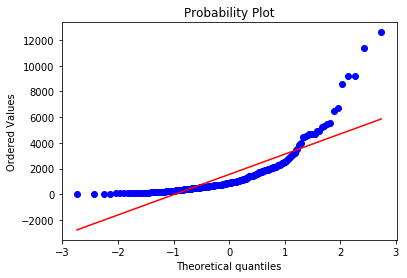

In [26]:
#QQ plot with stats.probplot to check for normality
normality_check = stats.probplot(london_invoices['Invoice_total'], plot = plt)

Not particularly normal, but less flamboyantly abnormal than our sample from the first hypothesis test.

We can compare these two populations directly. We won't take samples from them. And since we want to know whether one was greater than/less than the other, we'll use a one-tailed test.

## The experiment: a one-tailed t-test

In [27]:
#Value to compare to p-value
alpha = 0.05

#A control group from the London invoices
#A treatment group from the PNW invoices
control2 = london_invoices['Invoice_total']
treatment2 = pnw_invoices['Invoice_total']

We'll use a t-statistic calculated in a SciPy module to find a p-value to compare to the alpha value here.

C:\Users\Stee\Anaconda3good\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


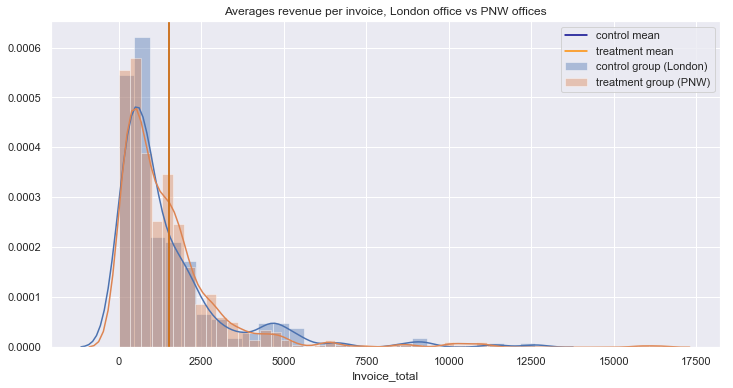

In [28]:
#Plot both distributions

sns.set(color_codes = True)
sns.set(rc={'figure.figsize':(12,6)})
sns.distplot(control2, label = "control group (London)")
sns.distplot(treatment2, label = "treatment group (PNW)")
plt.axvline(control2.mean(), color = 'darkblue', label = 'control mean')
plt.axvline(treatment2.mean(), color = 'darkorange', label = 'treatment mean')
plt.title('Averages revenue per invoice, London office vs PNW offices')
plt.legend()
plt.show()

In [29]:
print('London office invoice mean:', control2.mean())
print('Number of London offices invoices:', len(control2))
print('\n')
print('PNW office invoice mean:', treatment2.mean())
print('Number of PNW office invoices:', len(treatment2))

London office invoice mean: 1538.311220982143
Number of London offices invoices: 224


PNW office invoice mean: 1520.1507029702975
Number of PNW office invoices: 606


In [30]:
t2, p2 = stats.ttest_ind(control2,treatment2, equal_var = False)
print('T stat is', t2)
print('P-value is', p2)
if p2 > alpha:
    print('P-value is too high to reject null hypothesis.')
print('Cohen\'s D is', cohend(control2, treatment2))

T stat is 0.12383782386231988
P-value is 0.9015080381474158
P-value is too high to reject null hypothesis.
Cohen's D is 0.005109731621819946


### Result

Failure to reject null hypothesis. Invoice totals from the London office are, on average, the same or higher than the invoice totals from the PNW offices.

*However . . .*

There's a different way of looking at this issue. London sales reps may be getting the same amount of revenue from their invoices as the PNW sales reps, but what if they are getting fewer invoices overall? They may be generating less revenue for Northwind if they are fulfilling few orders.

2019-02-06 11:22:29,997 INFO sqlalchemy.engine.base.Engine SELECT e.LastName, e.City, e.HireDate,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Revenue
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            GROUP BY e.LastName
                            ORDER BY Revenue DESC
                    
2019-02-06 11:22:29,997 INFO sqlalchemy.engine.base.Engine ()


Text(0.5,1,'Total revenue per sales rep')

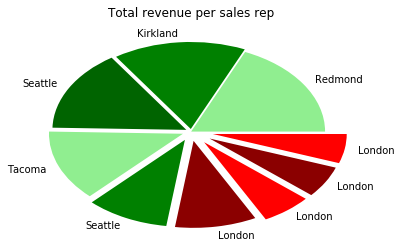

In [38]:
#How much revenue is generated by each employee?
#Revenue per employee
emp_rev = pd.read_sql_query('''SELECT e.LastName, e.City, e.HireDate,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Revenue
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            GROUP BY e.LastName
                            ORDER BY Revenue DESC
                    ''', engine)

#Visualize revenue by employee with a pie chart:
#Revenue by employee
revs = list(emp_rev['Revenue']) 
#Amount for each slice to stick out (Smaller revs stick out more)
stickout = list((revs[0] - x) * 0.000001 for x in revs)
#Labels for slices
offices = list(emp_rev['City'])
#Greens for PNW, reds for London
colors = ['lightgreen', 'green', 'darkgreen', 'lightgreen', 'green', 'darkred', 'red', 'darkred', 'red']
#Plot the pie chart
plt.pie(revs, explode = stickout, labels = offices, colors = colors)
plt.title('Total revenue per sales rep')

The employees in the London office are generating less revenue than the employees in the PNW office.

## Insights

Our experiment showed that invoice totals from the London sales reps are not, in fact, lower than those of the PNW office. However, the 4 **London employees generate less overall revenue.** In order to match the PNW employees, the London employees would need to fulfill more orders.

But can they? **We don't know why** they aren't fulfilling as many orders: do they have more bureaucratic hurdles to overcome? Are their customers more difficult? **Are they just lazy?** In order to come up with next steps for the London office, we will **need to collect more data**.

<a id="hypo3"></a>

[(Back to top)](#top)

# Hypothesis Test 3: Sales in 2013 v. 2014

>Did average sales decline in 2014 compared to 2013?

### What are we measuring?

There is more than one way of measuring sales. We could calculate total revenue in each year, but that would depend on our having records of all sales in both years. We will use the average of invoice totals because they are an intuitive unit for those making the sales, our employees, and for those making payment, our customers.

### The hypotheses

>**Null hypothesis**: Average sales in 2013 were less than or equal to average sales in 2014.

>>Control3 (2013 sales) <= Treatment3 (2014 sales)

>**Alternative hypothesis**: Average sales in 2013  were greater than average sales in 2014.

>>Control3 (2013 sales) > Treatment3 (2014 sales)

### The data

Average sales will be measured by taking the mean of invoice totals associated with each year. Each invoice total will be the sum of subtotals per order, where each subtotal on an order is unit price * (1 - discount) * quantity.

In [32]:
#Get invoices for 2013
invoices_2013 = pd.read_sql_query('''SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            WHERE o.OrderDate LIKE "2013%"
                            GROUP BY od.OrderId
                    ''', engine)
#Get invoices for 2013
invoices_2014 = pd.read_sql_query('''SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            WHERE o.OrderDate LIKE "2014%"
                            GROUP BY od.OrderId
                    ''', engine)

2019-02-04 13:50:24,943 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            WHERE o.OrderDate LIKE "2013%"
                            GROUP BY od.OrderId
                    
2019-02-04 13:50:24,944 INFO sqlalchemy.engine.base.Engine ()
2019-02-04 13:50:24,950 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            WHERE o.OrderDate LIKE "2014%"
                            GROUP BY od.OrderId
                    
2019-02-04 13:50:24,950 INFO sqlalchemy.engine.base.Engine ()


In [33]:
#Take a look at the data
invoices_2013.head()

,OrderId,Invoice_total
0,10400,3063.000
1,10401,3868.600
2,10402,2713.500
3,10403,855.015
4,10404,1591.250


In [34]:
invoices_2013.shape[0], invoices_2014.shape[0]

(408, 270)

Large samples sizes to work with. How normally distributed is the data?

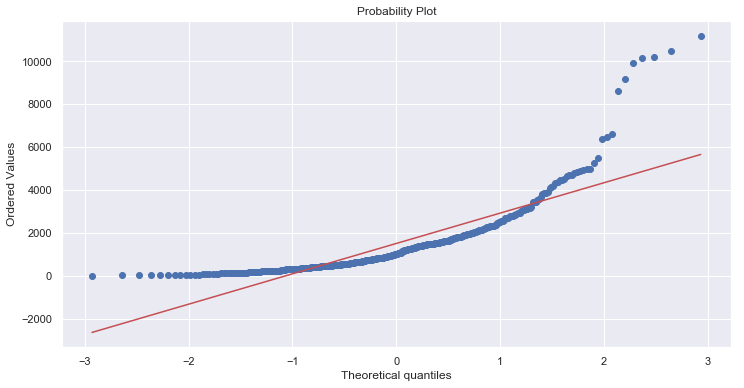

In [57]:
#QQ plot with stats.probplot to check for normality
normality_check = stats.probplot(invoices_2013['Invoice_total'], plot = plt)

Between the ample sample size and the good stretch of the data that follows a theoretical normal curve, we can be satisfied that a t-test will be appropriate here.

### The experiment: a one-tailed t-test

In [35]:
alpha = 0.05

#Control group from 2013 invoices
#Treatment group from 2014 invoices
control3 = invoices_2013['Invoice_total']
treatment3 = invoices_2014['Invoice_total']

C:\Users\Stee\Anaconda3good\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


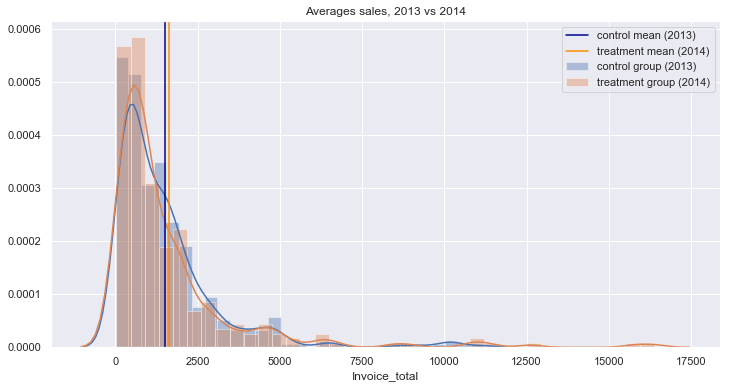

In [36]:
#Plot the distributions
sns.set(color_codes = True)
sns.set(rc={'figure.figsize':(12,6)})
sns.distplot(control3, label = "control group (2013)")
sns.distplot(treatment3, label = "treatment group (2014)")
plt.axvline(control3.mean(), color = 'darkblue', label = 'control mean (2013)')
plt.axvline(treatment3.mean(), color = 'darkorange', label = 'treatment mean (2014)')
plt.title('Averages sales, 2013 vs 2014')
plt.legend()
plt.show()

In [37]:
t3, p3 = stats.ttest_ind(control3, treatment3, equal_var = False)
print('T stat is', t3)
print('P-value is', p3)
if p3 > alpha:
    print('P-value is too high to reject null hypothesis.')
print('Cohen\'s D is', cohend(control3, treatment3))

T stat is -0.7448729960407308
P-value is 0.4567315145182581
P-value is too high to reject null hypothesis.
Cohen's D is -0.04818078173435724


### Result

Failure to reject null hypothesis.  Average sales in 2013 were less than or equal to average sales in 2014.

*But what if . . .*

What if lower revenue taken in by Northwind was lower in 2013 than in 2014? This is easy to calculate from the tables we've already created.

In [38]:
print('Revenue in 2013:', round(invoices_2013['Invoice_total'].sum(), 2))
print('Revenue in 2014:', round(invoices_2014['Invoice_total'].sum(), 2))

Revenue in 2013: 617085.2
Revenue in 2014: 440623.87


Revenue was lower in 2014! As a sanity check, we should make sure that orders were fulfilled throughout the full calendar year.

In [39]:
#Modified query to show and order by datetime in descending order (most recent date first)
invoices_2014_by_date = pd.read_sql_query('''SELECT od.OrderId, o.OrderDate,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            WHERE o.OrderDate LIKE "2014%"
                            GROUP BY od.OrderId
                            ORDER BY o.OrderDate DESC
                    ''', engine)
invoices_2014_by_date.head()

2019-02-04 13:50:44,895 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId, o.OrderDate,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            WHERE o.OrderDate LIKE "2014%"
                            GROUP BY od.OrderId
                            ORDER BY o.OrderDate DESC
                    
2019-02-04 13:50:44,896 INFO sqlalchemy.engine.base.Engine ()


,OrderId,OrderDate,Invoice_total
0,11074,2014-05-06,232.0850
1,11075,2014-05-06,498.1000
2,11076,2014-05-06,792.7500
3,11077,2014-05-06,1255.7205
4,11070,2014-05-05,1629.9750


So the last order from 2014 was placed in May. The invoices from the rest of the year are missing.

## Insights

Whoever made the original complaint about declining revenue has not been vindicated--yet. **Revenue per sale did not fall** from 2013 to 2014, and we **don't know for sure if overall revenue fell** because the records aren't complete.

It wasn't the case that sales reps "pushed harder" on each sale in 2013; nor was it the case that they started slacking in 2014. 

If we can get our hands on the invoices for the rest of the year 2014, we'll be able to make comparisons about overall revenue.

<a id="hypo4"></a>

[(Back to top)](#top)

# Hypothesis test 4: Orders and beverages

>Do orders containing beverages bring in more revenue on average than orders without beverages?

### What are we measuring?

In an effort to boost revenue, sales reps are often asked to try to push the customer to add cases of beverages onto an order before it gets fulfilled. We will measure whether this works: we will compare the invoice totals for orders that contained any beverages versus those that didn't.

### The hypotheses

>**Null hypothesis**: Invoice totals for orders not containing beverages are greater than or equal to totals for orders containing beverages.

>>Control4 (orders without beverages) >= Treatment4 (orders with beverages)

>**Alternative hypothesis**: Invoice totals for orders not containing beverages are less than invoice totals for orders containing beverages.

>>Control4 (orders without beverages) < Treatment4 (orders with beverages)

### The data

An invoice total will be the sum of subtotals per order, where each subtotal on an order is unit price * (1 - discount) * quantity. 

The control group will exclude invoices containing order details matching the "Beverage" product category. 

The treatment group exclude invoices without order details matching the "Beverage" product category.

In [40]:
#Get invoice subtotals by product category
cat_subtotals = pd.read_sql_query('''SELECT od.OrderId, e.LastName,
                            SUM(CASE WHEN c.CategoryName == 'Beverages'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
                                ELSE 0 END
                                ) Bev_rev,
                            SUM(CASE WHEN c.CategoryName == 'Dairy Products'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
                                ELSE 0 END
                                ) Dairy_rev,
                            SUM(CASE WHEN c.CategoryName == 'Confections'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
                                ELSE 0 END
                                ) Confe_rev,
                            SUM(CASE WHEN c.CategoryName == 'Meat/Poultry'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
                                ELSE 0 END
                                ) Meat_rev,
                            SUM(CASE WHEN c.CategoryName == 'Seafood'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
                                ELSE 0 END
                                ) Seaf_rev,
                            SUM(CASE WHEN c.CategoryName == 'Condiments'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
                                ELSE 0 END
                                ) Condi_rev,
                            SUM(CASE WHEN c.CategoryName == 'Produce'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
                                ELSE 0 END
                                ) Veg_rev,
                            SUM(CASE WHEN c.CategoryName == 'Grains/Cereals'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
                                ELSE 0 END
                                ) Grain_rev,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Product p ON od.ProductId = p.Id
                            JOIN Category c ON p.CategoryId = c.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            GROUP BY od.OrderId
                            ORDER BY od.OrderId
                    ''', engine)

2019-02-04 13:50:48,462 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId, e.LastName,
                            SUM(CASE WHEN c.CategoryName == 'Beverages'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
                                ELSE 0 END
                                ) Bev_rev,
                            SUM(CASE WHEN c.CategoryName == 'Dairy Products'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
                                ELSE 0 END
                                ) Dairy_rev,
                            SUM(CASE WHEN c.CategoryName == 'Confections'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
                                ELSE 0 END
                                ) Confe_rev,
                            SUM(CASE WHEN c.CategoryName == 'Meat/Poultry'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
      

In [41]:
#Take a look at the data
cat_subtotals.head(10)

,OrderId,LastName,Bev_rev,Dairy_rev,Confe_rev,Meat_rev,Seaf_rev,Condi_rev,Veg_rev,Grain_rev,Invoice_total
0,10248,Buchanan,0.0,342.0,0.0,0.00,0.0,0.0,0.0,98.00,440.00
1,10249,Suyama,0.0,0.0,0.0,0.00,0.0,0.0,1863.4,0.00,1863.40
2,10250,Peacock,0.0,0.0,0.0,0.00,77.0,214.2,1261.4,0.00,1552.60
3,10251,Leverling,0.0,0.0,0.0,0.00,0.0,336.0,0.0,318.06,654.06
4,10252,Peacock,0.0,1135.5,2462.4,0.00,0.0,0.0,0.0,0.00,3597.90
5,10253,Leverling,604.8,200.0,640.0,0.00,0.0,0.0,0.0,0.00,1444.80
6,10254,Buchanan,45.9,0.0,0.0,342.72,0.0,0.0,168.0,0.00,556.62
7,10255,Dodsworth,304.0,1320.0,486.5,0.00,380.0,0.0,0.0,0.00,2490.50
8,10256,Leverling,0.0,0.0,0.0,393.00,0.0,124.8,0.0,0.00,517.80
9,10257,Peacock,86.4,0.0,877.5,0.00,0.0,156.0,0.0,0.00,1119.90


In [42]:
print(cat_subtotals[cat_subtotals['Bev_rev'] == 0.0]['Invoice_total'].shape[0]) 
print(cat_subtotals[cat_subtotals['Bev_rev'] != 0.0]['Invoice_total'].shape[0])

476
354


We can compare these populations directly, without sampling.

### The experiment:  a one-tailed t-test

In [43]:
#A control group for invoice totals without beverages
control4 = cat_subtotals[cat_subtotals['Bev_rev'] == 0.0]['Invoice_total']
#A control group for invoice totals with beverages
treatment4 = cat_subtotals[cat_subtotals['Bev_rev'] != 0.0]['Invoice_total']

C:\Users\Stee\Anaconda3good\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


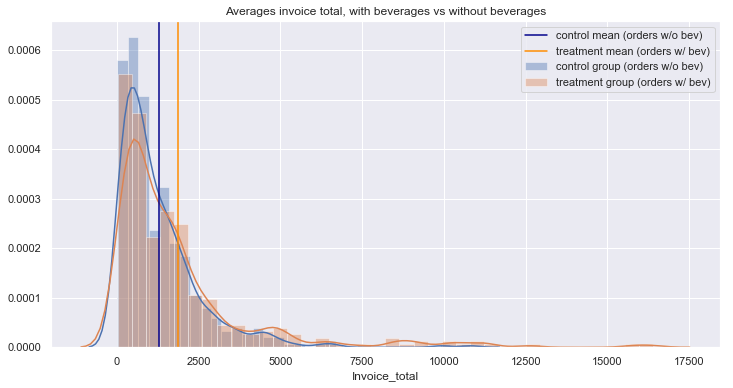

In [44]:
alpha = 0.05

#Plot the distribution
sns.set(color_codes = True)
sns.set(rc={'figure.figsize':(12,6)})
sns.distplot(control4, label = "control group (orders w/o bev)")
sns.distplot(treatment4, label = "treatment group (orders w/ bev)")
plt.axvline(control4.mean(), color = 'darkblue', label = 'control mean (orders w/o bev)')
plt.axvline(treatment4.mean(), color = 'darkorange', label = 'treatment mean (orders w/ bev)')
plt.title('Averages invoice total, with beverages vs without beverages')
plt.legend()
plt.show()

In [45]:
t4, p4 = stats.ttest_ind(control4, treatment4, equal_var = False)
print('T stat is', t4)
print('P-value is', p4)
if p4 > alpha:
    print('P-value is too high to reject null hypothesis.')
elif p4 < alpha:
    print('P-value is low enough to reject null hypothesis.')
print('Cohen\'s D is', cohend(control4, treatment4))

T stat is -4.266735540401764
P-value is 2.3665448470393296e-05
P-value is low enough to reject null hypothesis.
Cohen's D is -0.24558713312953565


### Result

Null hypothesis rejected. Invoice totals for orders not containing beverages are less than invoice totals for orders containing beverages.

The Cohen's d of |0.24| indicates only a "small" effect. What about the difference in means?

In [46]:
print(control4.mean(), treatment4.mean(), control4.mean() - treatment4.mean())
print(control4.std(), treatment4.std())

1272.880589285715 1864.1296016949154 -591.2490124092005
1287.073404815906 2359.1473150862716


This difference in means is not trivial, but it isn't enormous as in Hypothesis Test 1 Part 2. It would appear to bolster the claim of a "small" effect offered by the Cohen's D.

## Insights

It's a common trope in the food service world that adding on drinks to food orders will boost revenue. Here it is borne out: the **orders with beverages have higher totals**. We recommend **formalizing the "drink push"** as part of every sale made by a rep to a customer.

It would be interesting to investigate which other categories boost revenue, and we've got the table set up for it already. What about adding something special from the confections category onto an order of cheap bulk grains? What about adding seafood to an order that already has meat? (e.g. "While you're buying proteins...)

<a id = "conclusions"></a>

[(Back to top)](#top)

# Conclusions

### Test 1: Presence of discount does not have an overall effect on the number of products ordered by a customer; at the individual discount level, it does

- Marketing department should neither push discounts nor stop offering them
- Collect more data on customer behavior when offered discounts: e.g. their interaction with the website order form


### Test 2: London sales reps do not sell less on average than PNW reps; they do sell less overall

- Do not (yet) push London sales reps to match revenue taken in by PNW reps
- Collect more data on the workflow of the London sales reps: e.g. bureaucratic hurdles

### Test 3: Sales in 2013 were not higher on average than sales in 2014; data on an overall sales comparison is inconclusive.

- Do not (yet) scold sales reps for not having "pushed harder" for each sale in 2014
- Gather remaining invoices for 2014 to calculate overall revenue


### Test 4: Orders without beverages bring in less revenue on average than orders with beverages

- Formalize the "drink push" as part of every sale made by a rep to a customer
- Collect data on the boost to revenue of other categories: e.g. confections added to bulk grains, seafood added to meat

<a id = "futurework"></a>

[(Back to top)](#top)

# Future Work

A starting point for more experiments in the future.

## Discounts

### Sales per product with and without discount

In [47]:
#Examine how often each product is sold with/without discount
product_discs = pd.read_sql_query('''SELECT p.ProductName, od.UnitPrice,
                            COUNT(od.Id) Times_ordered,
                            SUM(
                                CASE WHEN od.Discount == 0.0 
                                THEN 1 ELSE 0 END
                                ) not_discounted,
                            SUM(
                                CASE WHEN od.Discount != 0.0 
                                THEN 1 ELSE 0 END
                                ) discounted
                            FROM Product p
                            JOIN OrderDetail od on p.Id = od.ProductId
                            GROUP BY p.ProductName
                        ''', engine)

product_discs.head(10)

2019-02-04 13:51:10,855 INFO sqlalchemy.engine.base.Engine SELECT p.ProductName, od.UnitPrice,
                            COUNT(od.Id) Times_ordered,
                            SUM(
                                CASE WHEN od.Discount == 0.0 
                                THEN 1 ELSE 0 END
                                ) not_discounted,
                            SUM(
                                CASE WHEN od.Discount != 0.0 
                                THEN 1 ELSE 0 END
                                ) discounted
                            FROM Product p
                            JOIN OrderDetail od on p.Id = od.ProductId
                            GROUP BY p.ProductName
                        
2019-02-04 13:51:10,856 INFO sqlalchemy.engine.base.Engine ()


,ProductName,UnitPrice,Times_ordered,not_discounted,discounted
0,Alice Mutton,39.00,37,21,16
1,Aniseed Syrup,10.00,12,10,2
2,Boston Crab Meat,18.40,41,25,16
3,Camembert Pierrot,34.00,51,28,23
4,Carnarvon Tigers,62.50,27,14,13
5,Chai,18.00,38,22,16
6,Chang,19.00,44,19,25
7,Chartreuse verte,18.00,30,16,14
8,Chef Anton's Cajun Seasoning,22.00,20,10,10
9,Chef Anton's Gumbo Mix,21.35,10,6,4


In [48]:
#Did more products have higher sales with or without discounts?
total_products = product_discs.shape[0]
more_without_discs = product_discs[product_discs['not_discounted'] > product_discs['discounted']]
more_with_discs = product_discs[product_discs['not_discounted'] < product_discs['discounted']]

print('Products with higher sales when not discounted:', more_without_discs.shape[0])
print('Products with higher sales when discounted:', more_with_discs.shape[0])
if more_without_discs.shape[0] > more_with_discs.shape[0]:
    print("More products had higher sales without discounts than with discounts.")

Products with higher sales when not discounted: 64
Products with higher sales when discounted: 9
More products had higher sales without discounts than with discounts.


### Mean unit prices for products with and without discounts

In [49]:
#Did the products which had higher sales when discounted have a higher unit price on average?
mean_without = more_without_discs['UnitPrice'].mean()
mean_with = more_with_discs['UnitPrice'].mean()

print('Mean unit price for products which had higher sales when not discounted:',
      mean_without)
print('Mean unit price for products which had higher sales when discounted:',
     mean_with)

Mean unit price for products which had higher sales when not discounted: 29.53453125
Mean unit price for products which had higher sales when discounted: 26.883333333333333


### Revenue taken in on products with and without discounts

In [50]:
#Itemized Revenue by OrderDetail
itemized = pd.read_sql_query('''SELECT od.Id, od.OrderId, p.ProductName, od.UnitPrice, 
                            od.Quantity, od.Discount,
                            ((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Total_price
                            FROM OrderDetail od
                            JOIN Product p ON od.ProductId = p.Id
                        ''', engine)
itemized.head()

2019-02-04 13:51:17,502 INFO sqlalchemy.engine.base.Engine SELECT od.Id, od.OrderId, p.ProductName, od.UnitPrice, 
                            od.Quantity, od.Discount,
                            ((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Total_price
                            FROM OrderDetail od
                            JOIN Product p ON od.ProductId = p.Id
                        
2019-02-04 13:51:17,503 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductName,UnitPrice,Quantity,Discount,Total_price
0,10248/11,10248,Queso Cabrales,14.0,12,0.0,168.0
1,10248/42,10248,Singaporean Hokkien Fried Mee,9.8,10,0.0,98.0
2,10248/72,10248,Mozzarella di Giovanni,34.8,5,0.0,174.0
3,10249/14,10249,Tofu,18.6,9,0.0,167.4
4,10249/51,10249,Manjimup Dried Apples,42.4,40,0.0,1696.0


In [51]:
#Has higher revenue been taken in on products with or without discounts?

#Get invoice subtotals from only items that weren't discounted
subtotals_without_disc = itemized['Total_price'][itemized['Discount'] == 0.0]
#Get invoice subttoals from only items that were discounted
subtotals_with_disc = itemized['Total_price'][itemized['Discount'] != 0.0]

#Add up subtotals for all undiscounted items
revenue_without_disc = subtotals_without_disc.sum()
#Add up subtotals for all discounted items
revenue_with_disc = subtotals_with_disc.sum()

print('Revenue from undiscounted items:', revenue_without_disc)
print('Revenue from discounted items:', revenue_with_disc)
if revenue_without_disc > revenue_with_disc:
    print('Revenue was higher from undiscounted items.')

Revenue from undiscounted items: 750698.61
Revenue from discounted items: 515094.42949999997
Revenue was higher from undiscounted items.


## Discrepancies in unit prices

### How many products have different unit prices in the product table v. the order detail table?

In [52]:
#Discrepancies in unit prices between Product table and OrderDetail table
invoices_testing = pd.read_sql_query('''SELECT od.Id, od.OrderId, p.ProductName, p.UnitPrice UnitPriceP, 
                            od.UnitPrice UnitPriceOd, od.Quantity, od.Discount,
                            ((p.UnitPrice * (1 - od.Discount)) * od.Quantity) Total_price_with_P,
                            ((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Total_price_withOd
                            FROM OrderDetail od
                            JOIN Product p ON od.ProductId = p.Id
                        ''', engine)
invoices_testing.head(10)

2019-02-04 13:51:22,399 INFO sqlalchemy.engine.base.Engine SELECT od.Id, od.OrderId, p.ProductName, p.UnitPrice UnitPriceP, 
                            od.UnitPrice UnitPriceOd, od.Quantity, od.Discount,
                            ((p.UnitPrice * (1 - od.Discount)) * od.Quantity) Total_price_with_P,
                            ((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Total_price_withOd
                            FROM OrderDetail od
                            JOIN Product p ON od.ProductId = p.Id
                        
2019-02-04 13:51:22,399 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductName,UnitPriceP,UnitPriceOd,Quantity,Discount,Total_price_with_P,Total_price_withOd
0,10248/11,10248,Queso Cabrales,21.00,14.0,12,0.00,252.0000,168.00
1,10248/42,10248,Singaporean Hokkien Fried Mee,14.00,9.8,10,0.00,140.0000,98.00
2,10248/72,10248,Mozzarella di Giovanni,34.80,34.8,5,0.00,174.0000,174.00
3,10249/14,10249,Tofu,23.25,18.6,9,0.00,209.2500,167.40
4,10249/51,10249,Manjimup Dried Apples,53.00,42.4,40,0.00,2120.0000,1696.00
5,10250/41,10250,Jack's New England Clam Chowder,9.65,7.7,10,0.00,96.5000,77.00
6,10250/51,10250,Manjimup Dried Apples,53.00,42.4,35,0.15,1576.7500,1261.40
7,10250/65,10250,Louisiana Fiery Hot Pepper Sauce,21.05,16.8,15,0.15,268.3875,214.20
8,10251/22,10251,Gustaf's Knäckebröd,21.00,16.8,6,0.05,119.7000,95.76
9,10251/57,10251,Ravioli Angelo,19.50,15.6,15,0.05,277.8750,222.30


In [53]:
#How often is the Product unit price different from the OrderDetail unit price?
different_unit_prices = invoices_testing[invoices_testing['UnitPriceP'] != invoices_testing['UnitPriceOd']]
invoices_testing.shape[0], different_unit_prices.shape[0]

(2155, 658)